# Simple Gaussian Processes with Numpy

Based on https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

In [20]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets
%matplotlib inline

In [2]:
import holoviews as hv
hv.notebook_extension()
%output holomap='widgets' fig='svg'

# Gaussian distributions

Random variables are often modelled by a statistical distribution. A very common example is the Gaussian distribution, sometimes called the normal distribution. A Gaussian distribution is characterised by its mean (or expected) value, and its variance (level of noise).

The plot below shows 500 points sampled from a Gaussian distribution characterised by mu and var. Try changing their values to see how it affects the shape of the distribution.

In [ ]:
def plot_gaussian(mu, v):
    return hv.Scatter(np.random.normal(size=(100,2), loc=(mu, 0), scale=v), extents=(-3,-3,3,3))

dim_v = hv.Dimension('var', range=(0.1, 2.0))
dim_mu = hv.Dimension('mu', range=(-2.0, 2.0))

dmap = hv.DynamicMap(plot_gaussian, kdims=[dim_mu, dim_v])
dmap

In the example above, each sample is a 2-dimensional vector. In principle, we can sample from a distribution with any number of dimensions in a similar way.

However, there is something missing from this example. Even though we are in a 2-dimensional space, we only have a single scalar value for each of the mean and the variance. Because of this, changing the mean only moves the distribution from left to right, not up and down. In addition, changing the variance can only make the distribution more or less spread out, but does not change its shape.

In [ ]:
def plot_gaussian(mu1, mu2, v1, v2):
    xs = np.random.normal(size=(100), loc=(mu1), scale=v1)
    ys = np.random.normal(size=(100), loc=(mu2), scale=v2)
    return hv.Scatter(np.dstack((xs, ys)).reshape(100,2), extents=(-3,-3,3,3))

dim_vs = [hv.Dimension('var_'+d, range=(0.1, 1.0)) for d in ['x', 'y']]
dim_mus = [hv.Dimension('mu_'+d, range=(-1.0, 1.0)) for d in ['x', 'y']]

dmap = hv.DynamicMap(plot_gaussian, kdims=dim_mus+dim_vs)
dmap

We now have 2-dimensional mean and variance values - but there is still something missing. Although changing the variance values can now alter the shape of the distribution, the result is always symmetric in the x and y dimensions. There are plenty of valid Gaussian distributions that don't have this kind of symmetry, like the one below.

In [ ]:
hv.Scatter(np.random.multivariate_normal(mean=(0, 0), cov=np.array([[10,4],[1,1]]), size=[300]))

In this case, it's not enough to know how much the x and y components vary. We also need a measure of how much the two vary together. This is captured in a structure called the _covariance matrix_. It has four components, which describe the seperate and joint variances of the two dimensions.

 |  |  
 --- | --- |  
How much x varies | How y varies with x
How x varies with y | How much y varies

The widget below shows the covariance matrices and corresponding distributions for a range of covariance values, given some fixed variances for x and y.

In [ ]:
%opts Raster style(cmap='bone_r')

def plot_covariance(v11, v22, v12, v21):
    return hv.Raster(np.array([[v11,v12],[v21,v22]]))

def plot_gaussian(v11, v22, v12, v21):
    return hv.Scatter(np.random.multivariate_normal(mean=(0, 0), cov=np.array([[v11,v12],[v21,v22]]), size=[20]))

vals = [-1.0, 0.0, 1.0, 2.0]
vals2 = [1.0, 3.0, 5.0]

dim_vs = [hv.Dimension('var_'+d, values=vals2) for d in ['x', 'y']] + \
        [hv.Dimension('cov_'+d, values=vals) for d in ['xy', 'yx']]
        
cov_maps = {(v11, v22, v12, v21): plot_covariance(v11, v22, v12, v21) for v11 in vals2 for v22 in vals2 for v12 in vals for v21 in vals}

dist_maps = {(v11, v22, v12, v21): plot_gaussian(v11, v22, v12, v21) for v11 in vals2 for v22 in vals2 for v12 in vals for v21 in vals}
    
cmap = hv.HoloMap(cov_maps, kdims=dim_vs, label="Covariance matrices")
dmap = hv.HoloMap(dist_maps, kdims=dim_vs, label="Distributions")
cmap.grid(dimensions=dim_vs[2:]) + dmap.grid(dimensions=dim_vs[2:])

We have seen that a Gaussian distribution in two dimensions can be described by six values, two describing the mean and four $(=2^2)$ describing the covariance. This holds true for any number of dimensions: a Gaussian distribution in n-dimensional space needs $n + n^2$ parameters to describe it.

# Gaussian processes

The previous section looked at Gaussian distributions over 2-dimensional vectors. Gaussian processes extend this idea to describe probability distributions over functions.

The key idea is to treat functions as members of a very high dimensional vector space, with each domain value $x_i$ corresponding to a different dimension. Then the function's definition is just a list of its values at each point. 

This definition leads naturally to the idea of a random function, where the components of the vector are chosen at random. In general, such functions will not even be continuous. The plot below shows a sample of a random function, with dotted lines showing interpolation between the points.

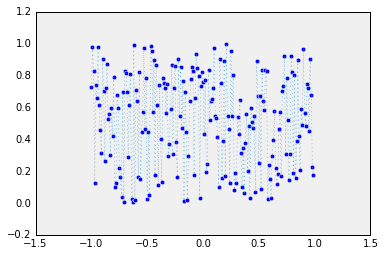

In [29]:
domain = np.arange(-1, 1, step=0.01)
values = [np.random.random() for x in domain]

matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['lines.linestyle'] = 'dotted'
plt.plot(domain, values)
plt.scatter(domain, values)

Gaussian processes are distributions over random functions. For each x-value, they define a Gaussian distribution over possible y-values. 

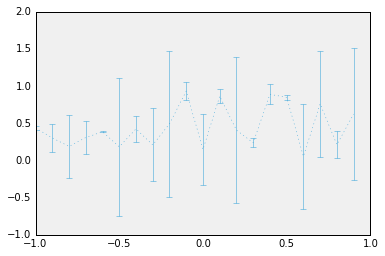

In [35]:
domain = np.arange(-1, 1, step=0.1)
values = [np.random.random() for x in domain]
errors = [np.random.random() for x in domain]
plt.errorbar(domain, values, errors)
matplotlib.rcParams['lines.linewidth'] = 1.0
matplotlib.rcParams['lines.linestyle'] = 'default'

The point of Gaussian processes is to be able to impose conditions on random functions. Two conditions which are particularly important for real applications are 1) continuity and 2) agreement with specific values at given points. The interaction between these two conditions is what drives Gaussian processes.

Recall that we are treating these functions as vectors over the space of the x-values. This gives us an analogy between the continuity of a random function and the covariance of a multivariate Gaussian distribution. Specifically, if the function is continuous, the covariance between dimensions representing neighbouring x-values will be close to one.

## The covariance function

In the first section, we saw that a Gaussian distribution is defined by a mean value and a covariance matrix. In a similar way, we can define a Gaussian process by specifying a mean function and a covariance function. 

The mean function is not considered to be very important, so it's generally set to be equal to zero. As discussed above, the covariance function can be seen as describing the similarity of nearby points.

We'll use a squared exponential covariance.

$$\begin{aligned} \mu(u) &=0 \\ k(u,v) &= \theta_1\exp\left(-\frac{\theta_2}{2}(u - v)^2\right) \end{aligned}$$

In [33]:
def exponential_cov(u, v, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(u, v)**2)

Here is what the squared exponential looks like for a couple of values.

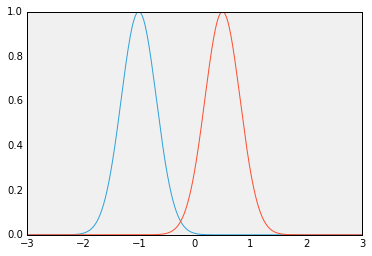

In [37]:
x_pred = np.linspace(-3, 3, 1000)
I = [1, 10]
plt.plot(x_pred, exponential_cov(-1.0, x_pred, I))
plt.plot(x_pred, exponential_cov(0.5, x_pred, I))

This covariance function approaches one when the input values are very similar, then drops away as the input values become more distinct. If we wished, we could use a different parameter to alter how quickly this happens.

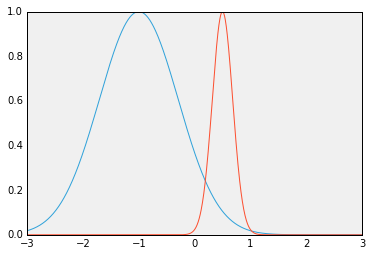

In [42]:
x_pred = np.linspace(-3, 3, 1000)
I = [1, 2]
plt.plot(x_pred, exponential_cov(-1.0, x_pred, I))
I = [1, 30]
plt.plot(x_pred, exponential_cov(0.5, x_pred, I))

This parameter corresponds to how quickly we expect our random function to change.

## Conditioning distributions

We can use the covariance to find the probability distribution of a point conditional on our current information.

$$p(u \mid v) = \mathcal{N}(\mu_u + \Sigma_{uv}\Sigma_v^{-1}(y_v-\mu_v), \Sigma_u-\Sigma_{uv}\Sigma_v^{-1}\Sigma_{uv}^T)$$

In [44]:
def conditional(u, v, y_v, params=[1, 10]):
    cov_u = exponential_cov(u, u, params) # = 1 if u is a scalar
    cov_v = exponential_cov(v, v, params) # = 1 if v is a scalar
    cov_uv = exponential_cov(u, v, params)
    
    cov_v_inv = np.linalg.inv(cov_v)
    cov_T_uv = exponential_cov(v, u, params)
    
    mu = cov_uv.dot(cov_v_inv).dot(y_v)
    sigma = cov_u - cov_uv.dot(cov_v_inv).dot(cov_T_uv)

    return(mu.squeeze(), sigma.squeeze())

This function takes in some known points, v, along with their values, y_v. The u parameter is the points we would like predictions for.

NB: Don't get confused by the word covariance - we are not finding the covariance between two series. We are _assuming_ a covariance function and using it to constrain the new values.

## Plotting the result

If we have values for points $v$, we can use our conditional function to constrain the values at other points in the domain. First, let's see what it looks like in the absence of prior information.

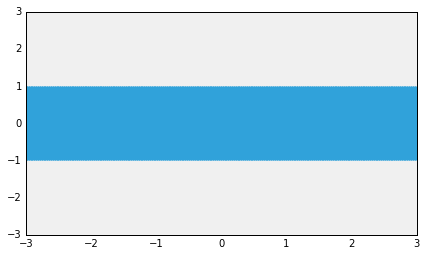

In [48]:
v = []
y_v = []

xpts = np.arange(-3, 3, step=0.01)
conds = [conditional(x, v, y_v) for x in xpts]

plt.figure(figsize=(7,4))
plt.errorbar(xpts, [c[0] for c in conds], yerr=[c[1] for c in conds], capsize=0)
plt.ylim(-3, 3)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")

This just has the 

In [ ]:
v = [-0.7, 2.0, -2.5]
y_v = [-0.3, -2.5, 0.5]

xpts = np.arange(-3, 3, step=0.01)
conds = [conditional(x, v, y_v) for x in xpts]

We assume the probability distributions for different inputs are independent conditional on the values at observed points. If we didn't make this assumption, it wouldn't make sense to condition each point seperately: we would have to condition the whole vector, and taken account of the whole covariance matrix. Instead, we only use the values on the diagonal. 

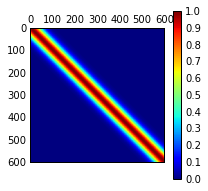

In [46]:
plt.figure(figsize=(3,3))
plt.matshow(conditional(xpts, v, y_v)[1], False)
plt.colorbar()

The variance values for each point are along the diagonal. Near the observed values, the variance is close to zero. Further away, the variance reverts to its original value of one.

In [ ]:
plt.figure(figsize=(7,4))
plt.errorbar(xpts, [c[0] for c in conds], yerr=[c[1] for c in conds], capsize=0)
plt.ylim(-3, 3)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")